In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt

import zuko
from zuko.mixtures import GMM

from tqdm.notebook import tqdm

In [3]:
means = torch.tensor([[-7.0, 0.0], [0.0, 0.0], [7.0, 0.0]])

# cov = torch.tensor([[2.0, 0.0], [0.0, 1.0]])
# cov with 45 degree angle
covs = torch.tensor([
    [[2.2, 0.0], [0.0, 2.2]],
    [[2.0, 0.0], [0.0, 1.0]],
    [[1.8, 0.8], [0.8, 0.8]],
])

true_dist = zuko.distributions.Mixture(
    torch.distributions.MultivariateNormal(means, covs), torch.tensor([1.0, 1.0, 1.0])
)

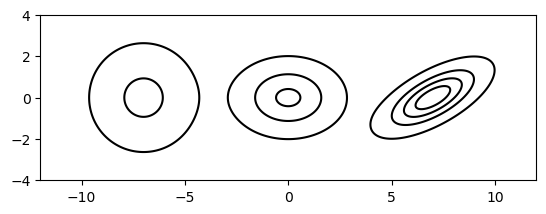

In [4]:
fig, ax = plt.subplots()

x = torch.linspace(-12.0, 12.0, 500)
y = torch.linspace(-4.0, 4.0, 500)

X, Y = torch.meshgrid(x, y, indexing="ij")
Z = torch.stack([X, Y], dim=-1).reshape(-1, 2)
logprob_true = true_dist.log_prob(Z).exp().reshape(500, 500)

ax.contour(X, Y, logprob_true.exp(), levels=4, colors="black")
ax.set_aspect("equal")

plt.show()

In [5]:
torch.manual_seed(0)

lr = 1e-2
components = 3

scenarios = [
    ["full", False],
    ["full", True],
    # ['lowrank', False, 2],
    # ['lowrank', True, 2],
    ["diag", False],
    ["diag", True],
    ["spherical", False],
    ["spherical", True],
]

gmm_list = [
    GMM(
        features=2,
        components=components,
        covariance_type=scenario[0],
        tied=scenario[1],
        # cov_rank=scenario[2] if len(scenario) > 2 else None,
    )
    for scenario in scenarios
]

optimizer_list = [torch.optim.Adam(gmm.parameters(), lr=lr) for gmm in gmm_list]
losses_list = [[] for _ in gmm_list]

for i, gmm in enumerate(gmm_list):

    if scenarios[i][0] == 'lowrank':
        continue

    gmm.initialize(
        true_dist.sample((1024,)),
        # strategy="kmeans++",
        strategy='kmeans',
        # strategy='random',
    )

    # for key, value in gmm.named_parameters():
    #     print(key, value.data)

# for gmm in gmm_list:
#     gmm.phi[1].data = means.clone()
#     print(gmm.phi[1].data)

for i in tqdm(range(500)):
    for gmm, optimizer, losses in zip(gmm_list, optimizer_list, losses_list):
        optimizer.zero_grad()
        samples = true_dist.sample((128,))
        loss = -gmm().log_prob(samples).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

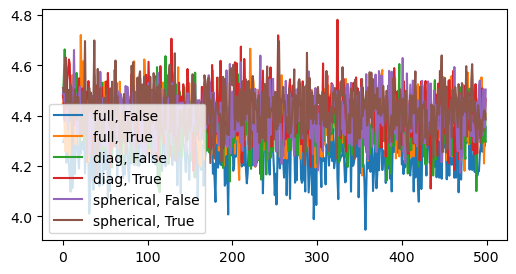

In [6]:
fig, ax = plt.subplots(figsize=(6, 3))

for i, losses in enumerate(losses_list):
    ax.plot(losses, label=f"{scenarios[i][0]}, {scenarios[i][1]}")

plt.legend()
plt.show()

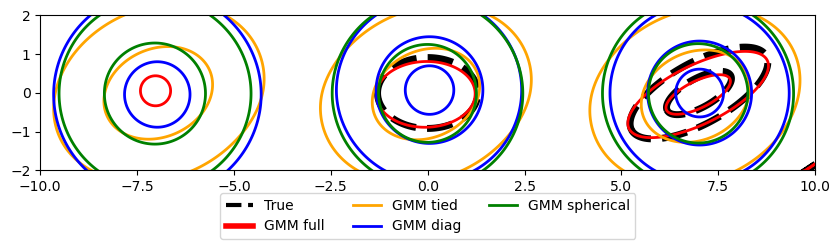

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

levels = 2

logprob_gmm_full = gmm_list[0]().log_prob(Z).exp().reshape(500, 500).detach()
logprob_gmm_full_tied = gmm_list[1]().log_prob(Z).exp().reshape(500, 500).detach()
# logprob_gmm_lowrank = gmm_list[2]().log_prob(Z).exp().reshape(500, 500).detach()
logprob_gmm_diag = gmm_list[4]().log_prob(Z).exp().reshape(500, 500).detach()
logprob_gmm_spherical = gmm_list[5]().log_prob(Z).exp().reshape(500, 500).detach()

ax.contour(
    X,
    Y,
    logprob_true.exp(),
    levels=levels,
    colors="black",
    linestyles="dashed",
    linewidths=5,
)
ax.plot([], [], color="black", linestyle="dashed", linewidth=3, label="True")

ax.contour(X, Y, logprob_gmm_full.exp(), levels=levels, colors="red", linewidths=2)
ax.plot([], [], color="red", label="GMM full", linewidth=4)

ax.contour(X, Y, logprob_gmm_full_tied.exp(), levels=levels, colors="orange", linewidths=2)
ax.plot([], [], color="orange", label="GMM tied", linewidth=2)

# ax.contour(
#     X, Y, logprob_gmm_lowrank.exp(), levels=levels, colors='purple', linewidths=2)
# ax.plot(
#     [], [], color='purple', label='GMM lowrank', linewidth=2)

ax.contour(X, Y, logprob_gmm_diag.exp(), levels=levels, colors="blue", linewidths=2)
ax.plot([], [], color="blue", label="GMM diag", linewidth=2)

ax.contour(X, Y, logprob_gmm_spherical.exp(), levels=levels, colors="green", linewidths=2)
ax.plot([], [], color="green", label="GMM spherical", linewidth=2)

ax.set_aspect("equal")

# legend below
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=True)


ax.set_xlim(-10, 10)
ax.set_ylim(-2, 2)

# ax.set_xticks([])
# ax.set_yticks([])

plt.show()

In [8]:
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

In [9]:
# print numeber of free parameters for each model

for gmm, scenario in zip(gmm_list, scenarios):
    print(f"{scenario}: {get_n_params(gmm)}")

['full', False]: 18
['full', True]: 12
['diag', False]: 15
['diag', True]: 11
['spherical', False]: 12
['spherical', True]: 10


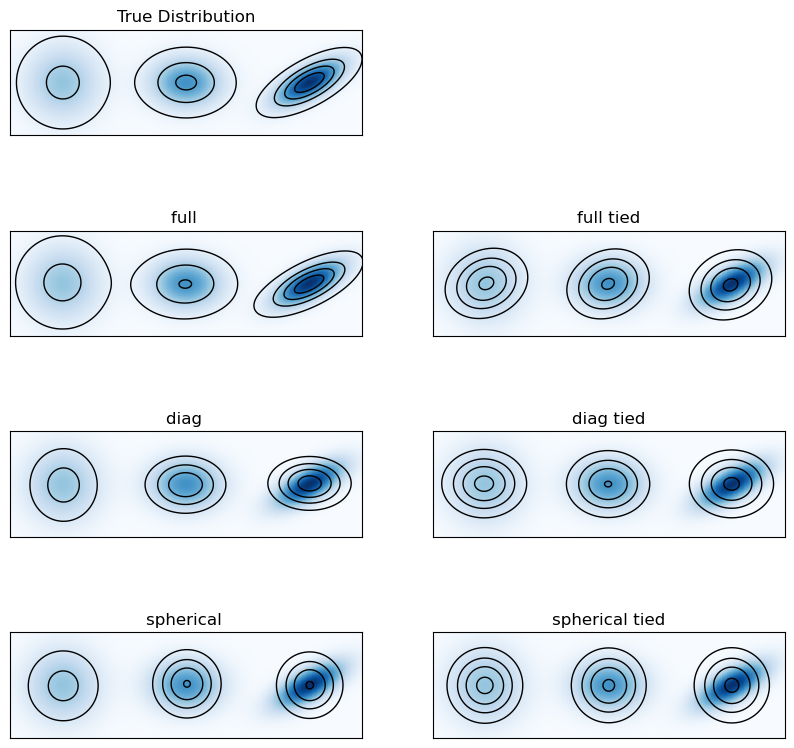

In [10]:
# plot each in thei own axis
levels = 4

fig, axs = plt.subplots(len(gmm_list) // 2 + 1, 2, figsize=(10, 10))

axs = axs.flatten()
# axs[0].contour(
#     X, Y, logprob_true, levels=levels, colors='black',
#     linestyles='dashed', linewidths=2,)
# axs[0].title.set_text('True')

axs[0].pcolormesh(X, Y, logprob_true.exp(), shading="auto", cmap="Blues")
axs[0].contour(X, Y, logprob_true.exp(), levels=levels, colors="black", linewidths=1)
axs[0].title.set_text("True Distribution")

# merge first two axes
axs[1].remove()

for ax, gmm in zip(axs[2:], gmm_list):
    ax.pcolormesh(X, Y, logprob_true.exp(), shading="auto", cmap="Blues")
    # ax.contour(
    #     X, Y, logprob_true, levels=levels, colors='blue', linewidths=0.5)

    logprob = gmm().log_prob(Z).exp().reshape(500, 500).detach()
    ax.contour(X, Y, logprob.exp(), levels=levels, colors="black", linewidths=1)
    ax.title.set_text(f'{gmm.covariance_type} {"tied" if gmm.tied else ""}')

for ax in axs:
    ax.set_aspect("equal")
    ax.set_xlim(-10, 10)
    ax.set_ylim(-3, 3)

    ax.set_xticks([])
    ax.set_yticks([])

plt.show()